In [22]:
import pandas as pd
import os
import sys

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)

from utils.cmod5n import cmod5n_forward, cmod5n_inverse
from utils.functions import *

import xarray as xr
from glob import glob

In [83]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")

df1 = create_phi_bins_columns(df1, 'phi_nominal_median', 1)
df2 = create_phi_bins_columns(df2, 'phi_nominal_median', 1)

df1r = pd.read_parquet("../results_15_May/wv1_results_updated.parquet")
df2r = pd.read_parquet("../results_15_May/wv2_results_updated.parquet")

df1w = pd.read_parquet("../results_25_May/wv1_wind_results.parquet")
df2w = pd.read_parquet("../results_25_May/wv2_wind_results.parquet")

df1r["renamed_filename"] = df1r.sar_filepath.apply(lambda x: x.split("/")[-1])
df2r["renamed_filename"] = df2r.sar_filepath.apply(lambda x: x.split("/")[-1])

df1w["renamed_filename"] = df1w.sar_filepath.apply(lambda x: x.split("/")[-1])
df2w["renamed_filename"] = df2w.sar_filepath.apply(lambda x: x.split("/")[-1])

idxmax = df1w.k_values_wind.apply(lambda x: len(x)).argmax()
max_len = df1w.k_values_wind.apply(lambda x: len(x)).max()

df1r = pad_arrays_to_max_length(df1r, 'radial_psd', max_len)
df2r = pad_arrays_to_max_length(df2r, 'radial_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_psd', max_len)

In [84]:
k_values = get_k_values(df1r, "k_values")
k_values = k_values/20

In [85]:
# df1_rg, df1r_rg, df1w_rg = create_dfs_from_phi_interval('[-90, -89)', df1, df1r, df1w)
# df2_rg, df2r_rg, df2w_rg = create_dfs_from_phi_interval('[-90, -89)', df2, df2r, df2w)

In [86]:
# plot_avg_spectral_density(k_values, [df2w_rg, df1w_rg], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                           "Average Wind PSD", 
#                           x_range=(0.0001, 0.15), y_range=(0, 0.5e8), 
#                           use_log_scale=False, wavelength=True, bootstrap=True);

In [87]:
df1w['phi'] = df1r.phi_nominal.copy()
df2w['phi'] = df2r.phi_nominal.copy()

In [88]:
df1w = create_phi_bins_columns(df1w, 'phi', 30)
df2w = create_phi_bins_columns(df2w, 'phi', 30)

In [90]:
df1w['mean_b2'] = df1w['b2'].apply(lambda x: get_mean(x))
df2w['mean_b2'] = df2w['b2'].apply(lambda x: get_mean(x))

In [91]:
df1_b2 = df1w[['mean_b2', 'phi_bins']].copy()
df2_b2 = df2w[['mean_b2', 'phi_bins']].copy()

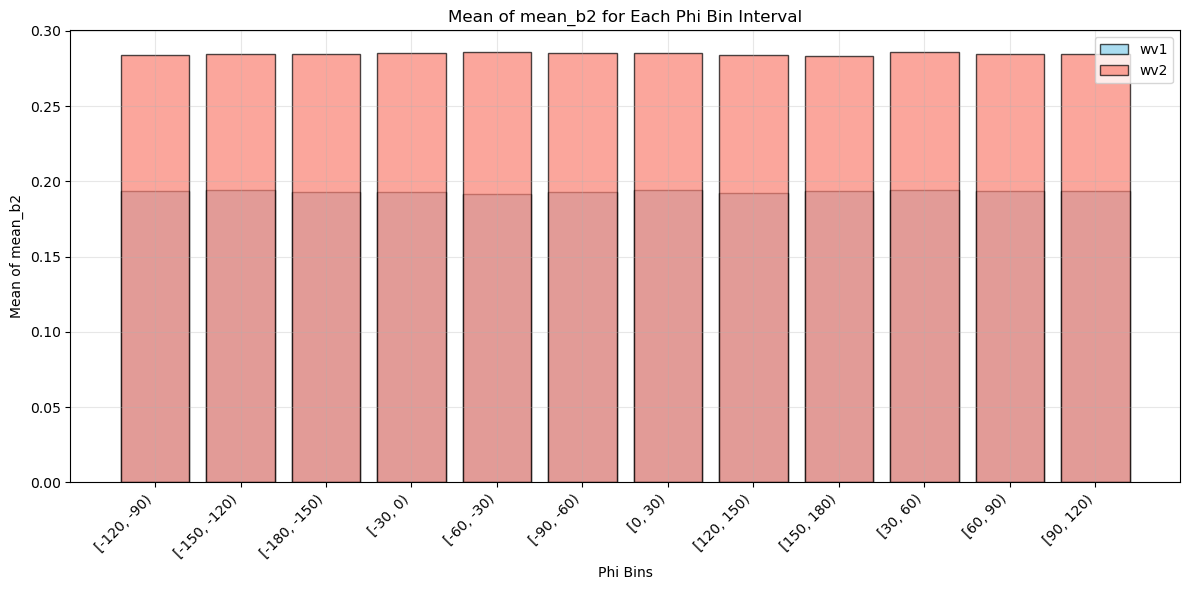

Mean of mean_b2 for each phi bin for WV1:
[-120, -90): 0.193444
[-150, -120): 0.194314
[-180, -150): 0.192675
[-30, 0): 0.192608
[-60, -30): 0.191835
[-90, -60): 0.193205
[0, 30): 0.194283
[120, 150): 0.192431
[150, 180): 0.193683
[30, 60): 0.194170
[60, 90): 0.193684
[90, 120): 0.193394

Mean of mean_b2 for each phi bin for WV2:
[-120, -90): 0.283961
[-150, -120): 0.284750
[-180, -150): 0.284889
[-30, 0): 0.285027
[-60, -30): 0.285993
[-90, -60): 0.285555
[0, 30): 0.284971
[120, 150): 0.283790
[150, 180): 0.283301
[30, 60): 0.285717
[60, 90): 0.284513
[90, 120): 0.284650


In [92]:
# Group by phi_bins and calculate the mean of mean_b2 for each bin
grouped_means1 = df1_b2.groupby('phi_bins')['mean_b2'].mean()
grouped_means2 = df2_b2.groupby('phi_bins')['mean_b2'].mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(grouped_means1)), grouped_means1.values, alpha=0.7, color='skyblue', edgecolor='black',
        label="wv1")
plt.bar(range(len(grouped_means2)), grouped_means2.values, alpha=0.7, color='salmon', edgecolor='black',
        label="wv2")
# Set x-axis labels to show the phi bin intervals
plt.xticks(range(len(grouped_means1)), grouped_means1.index, rotation=45, ha='right')
plt.xlabel('Phi Bins')
plt.ylabel('Mean of mean_b2')
plt.title('Mean of mean_b2 for Each Phi Bin Interval')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Print the results as well
print("Mean of mean_b2 for each phi bin for WV1:")
for bin_interval, mean_value in grouped_means1.items():
    print(f"{bin_interval}: {mean_value:.6f}")

print("\nMean of mean_b2 for each phi bin for WV2:")
for bin_interval, mean_value in grouped_means2.items():
    print(f"{bin_interval}: {mean_value:.6f}")


In [93]:
grouped_means_psd1 = df1w.groupby('phi_bins')['radial_wind_psd_padded'].mean()
grouped_means_psd2 = df2w.groupby('phi_bins')['radial_wind_psd_padded'].mean()

In [94]:
epsilon = 1e-10  # or any small number you prefer
psd_ratio = (grouped_means_psd1 + epsilon) / (grouped_means_psd2 + epsilon)
b2_mean_ratio = grouped_means1 / grouped_means2

In [95]:
def analyze_b_parameter_vs_psd(b_param_ratio, psd_ratio, k_values, param_name):
    """
    Analyze correlation between B-parameter ratio and PSD ratio across wavelengths.
    
    Parameters:
    -----------
    b_param_ratio : array-like
        Ratio of B-parameter (WV1/WV2) for each phi bin
    psd_ratio : DataFrame or array-like
        PSD ratios for each phi bin (rows) and wavelength (columns)
    k_values : array-like
        Wavenumber values
    param_name : str
        Name of the B-parameter for plotting (e.g., 'B0', 'B1', 'B2')
    """
    correlations = []
    wavelengths = 1/k_values
    
    for i in range(len(wavelengths)):
        psd_at_wavelength = [psd_ratio.iloc[j][i] for j in range(len(psd_ratio))]
        corr = np.corrcoef(b_param_ratio, psd_at_wavelength)[0,1]
        correlations.append(corr)
    
    plt.figure(figsize=(10, 6))
    plt.semilogx(wavelengths, correlations)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Wavelength [m]')
    plt.ylabel(f'Correlation({param_name}_ratio, PSD_ratio)')
    plt.title(f'{param_name} vs PSD Correlation Across Scales')
    plt.grid(True, alpha=0.3)
    
    return correlations, wavelengths


In [96]:
df1w['mean_b1'] = df1w['b1'].apply(lambda x: get_mean(x))
df2w['mean_b1'] = df2w['b1'].apply(lambda x: get_mean(x))

df1w['mean_b0'] = df1w['b0'].apply(lambda x: get_mean(x))
df2w['mean_b0'] = df2w['b0'].apply(lambda x: get_mean(x))

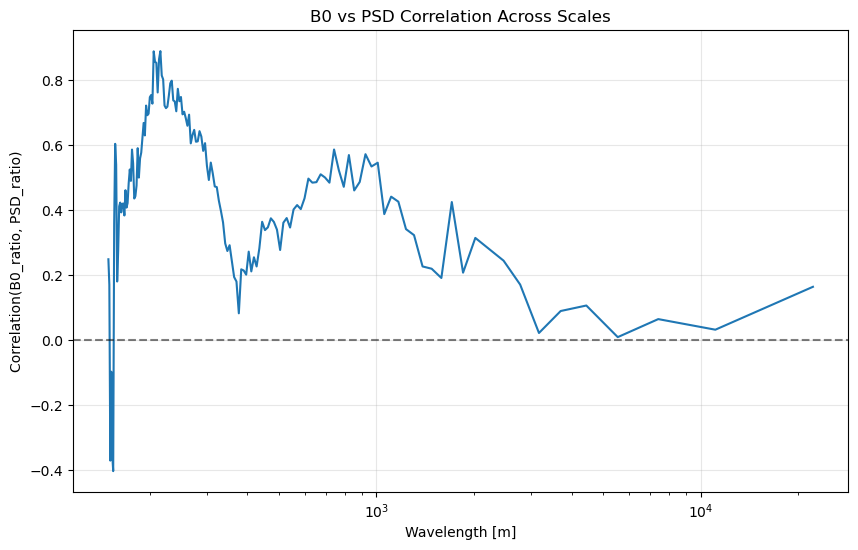

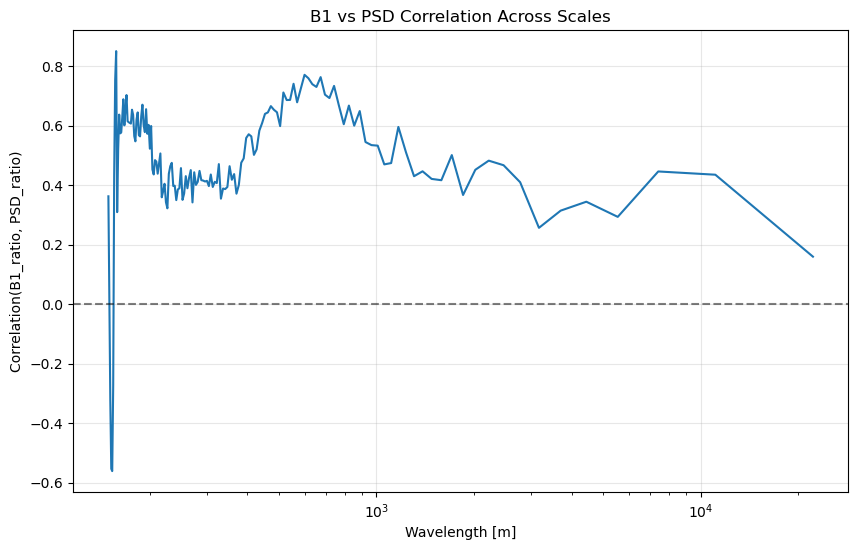

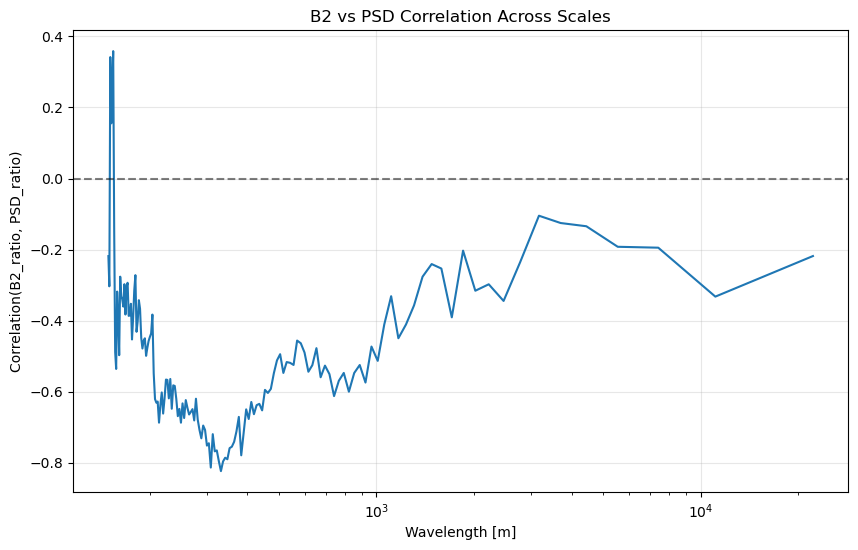

In [97]:
b0_mean_ratio = df1w.groupby('phi_bins')['mean_b0'].mean() / df2w.groupby('phi_bins')['mean_b0'].mean()
b1_mean_ratio = df1w.groupby('phi_bins')['mean_b1'].mean() / df2w.groupby('phi_bins')['mean_b1'].mean()

b0_correlations, wavelengths = analyze_b_parameter_vs_psd(b0_mean_ratio, psd_ratio, k_values, 'B0');
b1_correlations, wavelengths = analyze_b_parameter_vs_psd(b1_mean_ratio, psd_ratio, k_values, 'B1');
b2_correlations, wavelengths = analyze_b_parameter_vs_psd(b2_mean_ratio, psd_ratio, k_values, 'B2');


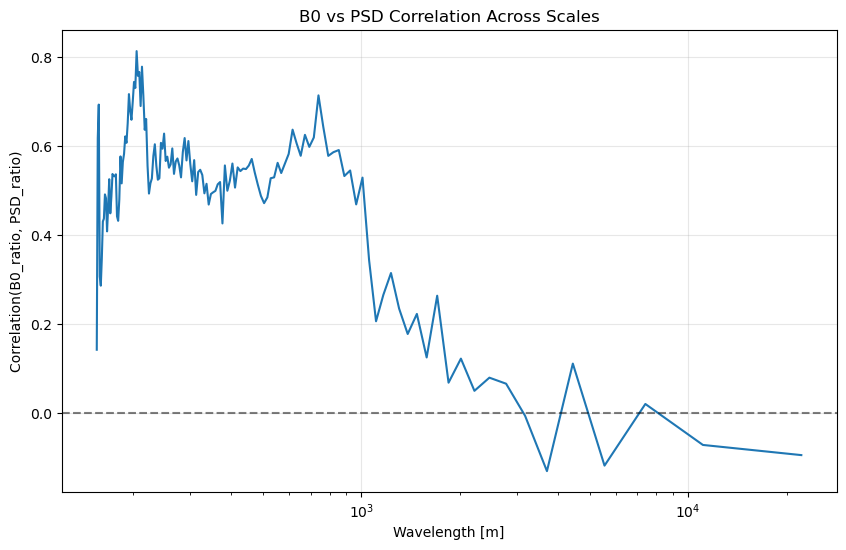

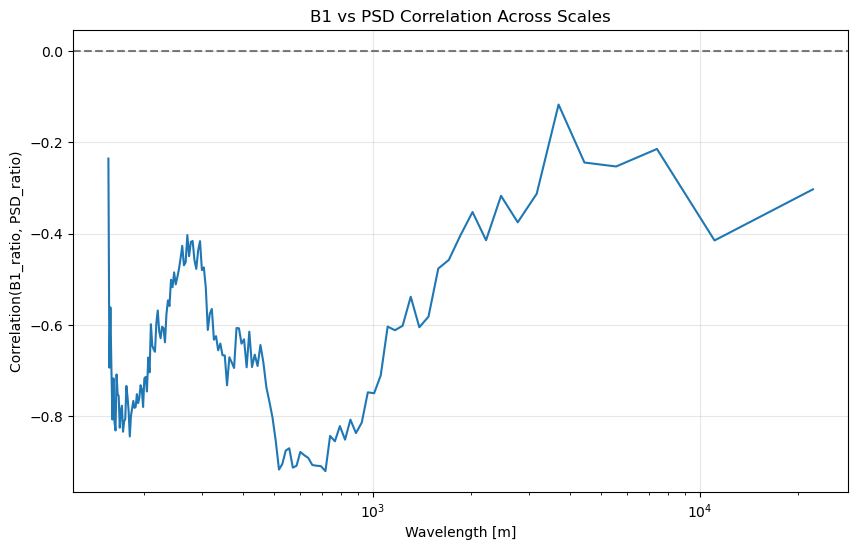

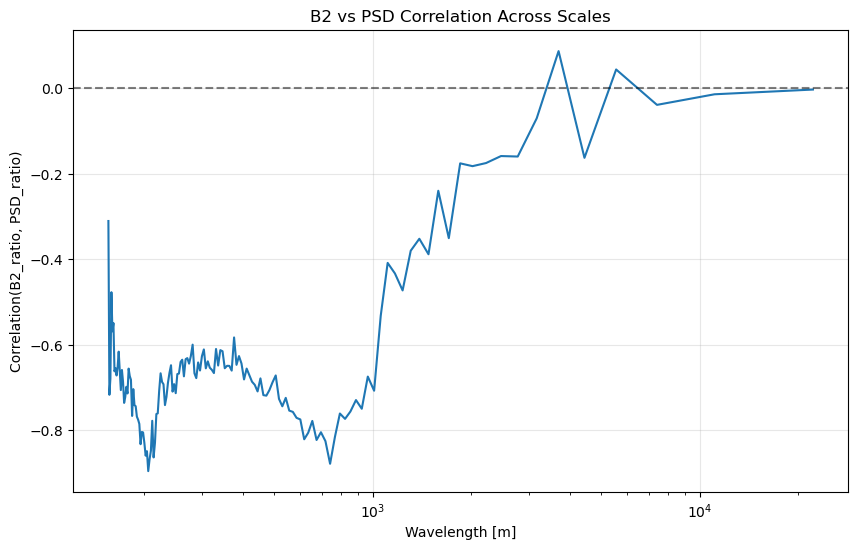

In [129]:
b0_mean_wv1 = df1w.groupby('phi_bins')['mean_b0'].mean()
b1_mean_wv1 = df1w.groupby('phi_bins')['mean_b1'].mean()
b2_mean_wv1 = df1w.groupby('phi_bins')['mean_b2'].mean()

b0_mean_wv2 = df2w.groupby('phi_bins')['mean_b0'].mean()
b1_mean_wv2 = df2w.groupby('phi_bins')['mean_b1'].mean()
b2_mean_wv2 = df2w.groupby('phi_bins')['mean_b2'].mean()

b0_correlations, wavelengths = analyze_b_parameter_vs_psd(b0_mean_wv2, grouped_means_psd2, k_values, 'B0')
b1_correlations, wavelengths = analyze_b_parameter_vs_psd(b1_mean_wv2, grouped_means_psd2, k_values, 'B1')
b2_correlations, wavelengths = analyze_b_parameter_vs_psd(b2_mean_wv2, grouped_means_psd2, k_values, 'B2')

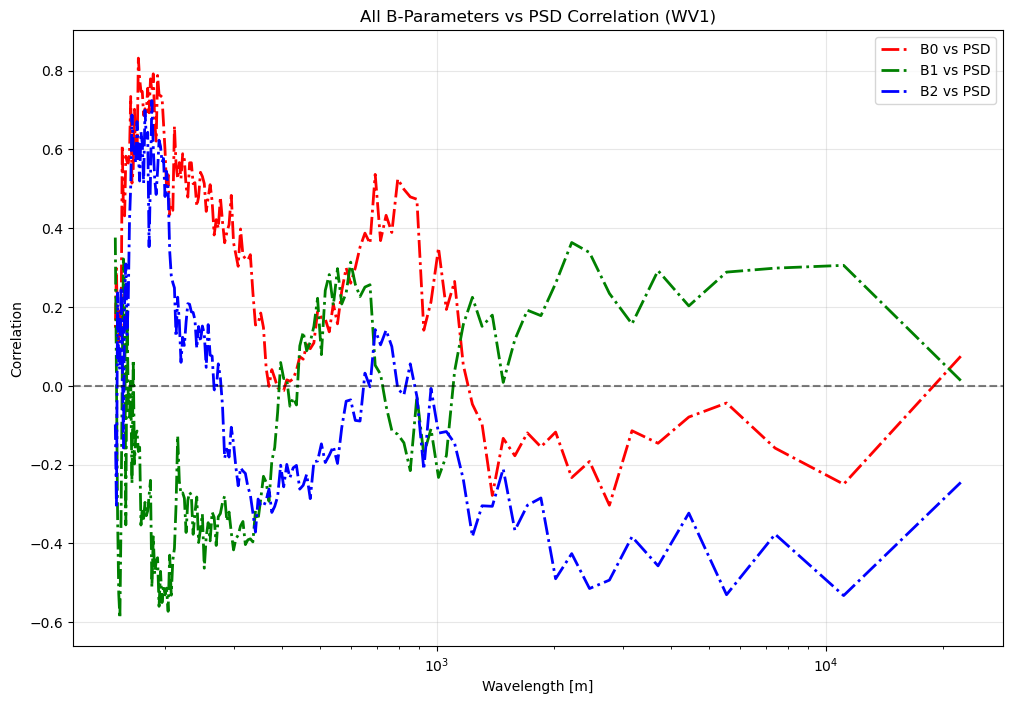

In [126]:
# Plot all three on the same figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.semilogx(wavelengths, b0_correlations, 'r-.', label='B0 vs PSD', linewidth=2)
ax.semilogx(wavelengths, b1_correlations, 'g-.', label='B1 vs PSD', linewidth=2)
ax.semilogx(wavelengths, b2_correlations, 'b-.', label='B2 vs PSD', linewidth=2)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Wavelength [m]')
ax.set_ylabel('Correlation')
ax.set_title('All B-Parameters vs PSD Correlation (WV1)')
ax.legend()
ax.grid(True, alpha=0.3)

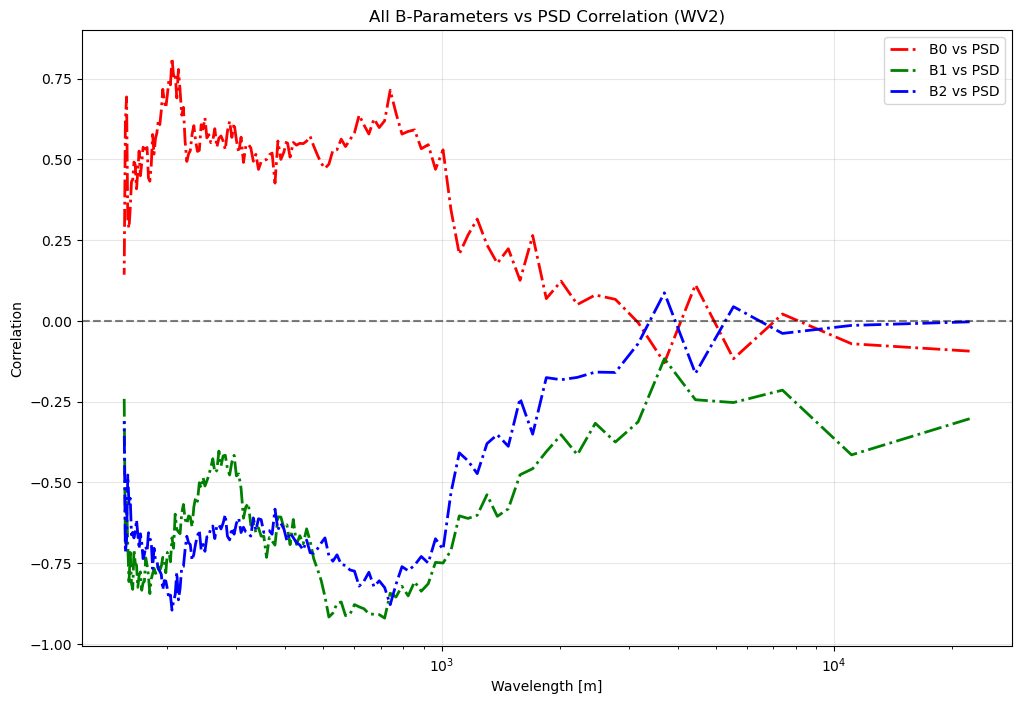

In [130]:
# Plot all three on the same figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.semilogx(wavelengths, b0_correlations, 'r-.', label='B0 vs PSD', linewidth=2)
ax.semilogx(wavelengths, b1_correlations, 'g-.', label='B1 vs PSD', linewidth=2)
ax.semilogx(wavelengths, b2_correlations, 'b-.', label='B2 vs PSD', linewidth=2)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Wavelength [m]')
ax.set_ylabel('Correlation')
ax.set_title('All B-Parameters vs PSD Correlation (WV2)')
ax.legend()
ax.grid(True, alpha=0.3)

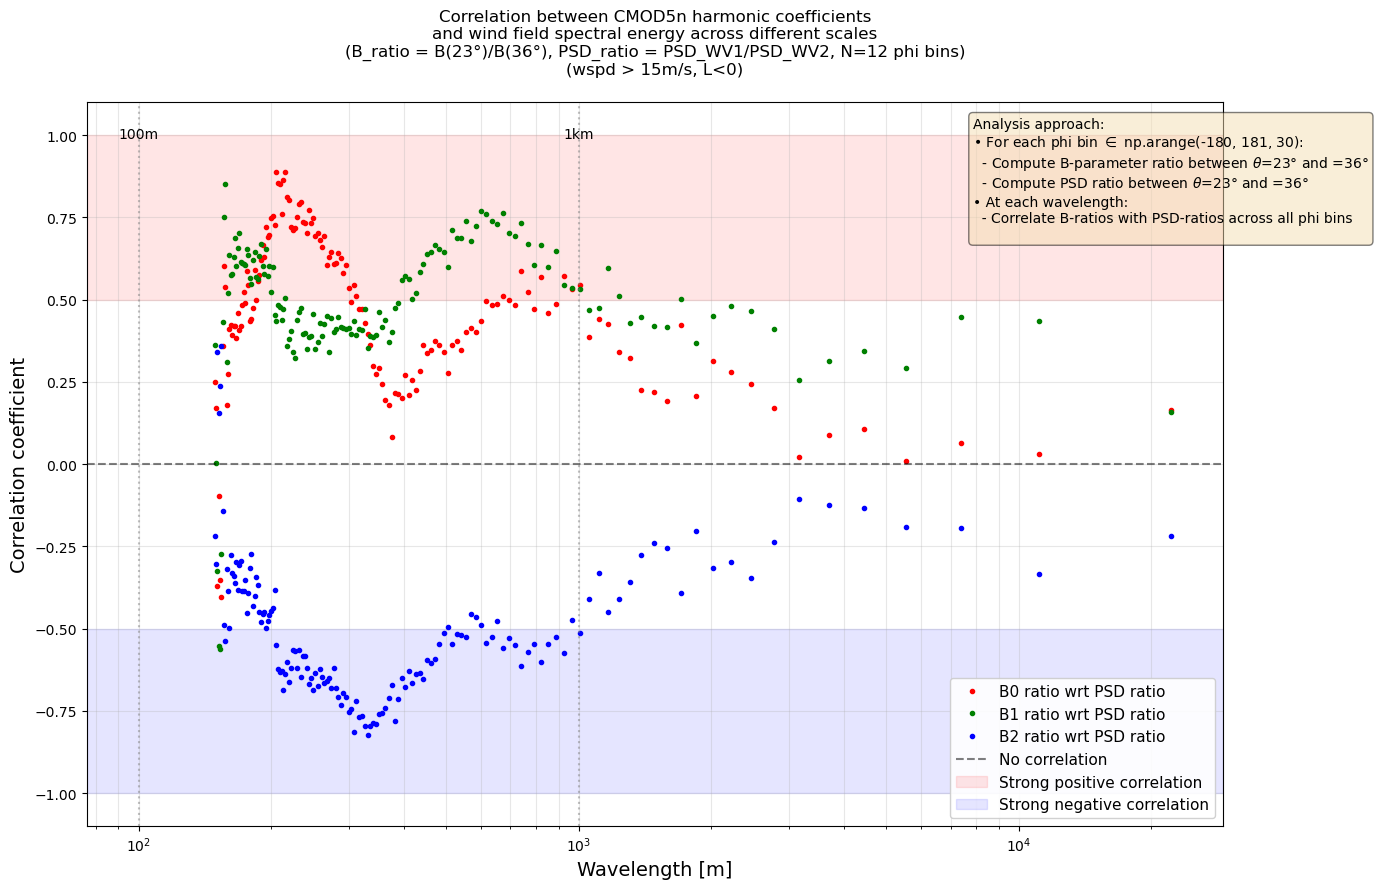

In [100]:
# Create figure with better explanation
fig, ax = plt.subplots(figsize=(14, 9))

# Plot correlations
ax.semilogx(wavelengths, b0_correlations, 'r.', label='B0 ratio wrt PSD ratio', linewidth=2.5)
ax.semilogx(wavelengths, b1_correlations, 'g.', label='B1 ratio wrt PSD ratio', linewidth=2.5)
ax.semilogx(wavelengths, b2_correlations, 'b.', label='B2 ratio wrt PSD ratio', linewidth=2.5)

# Add reference line
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No correlation')

# Add shaded regions for interpretation
ax.axhspan(0.5, 1.0, alpha=0.1, color='red', label='Strong positive correlation')
ax.axhspan(-1.0, -0.5, alpha=0.1, color='blue', label='Strong negative correlation')

# Labels and title
ax.set_xlabel('Wavelength [m]', fontsize=14)
ax.set_ylabel('Correlation coefficient', fontsize=14)

# More descriptive title
title = ('Correlation between CMOD5n harmonic coefficients\n'
         'and wind field spectral energy across different scales\n'
         f'(B_ratio = B(23°)/B(36°), PSD_ratio = PSD_WV1/PSD_WV2, N={len(b0_mean_ratio)} phi bins)\n'
         '(wspd > 15m/s, L<0)')
ax.set_title(title, fontsize=12, pad=20)

# Add text box explaining the analysis
textstr = ('Analysis approach:\n'
           '• For each phi bin $\in$ np.arange(-180, 181, 30):\n'
           '  - Compute B-parameter ratio between $\\theta$=23° and =36°\n'
           '  - Compute PSD ratio between $\\theta$=23° and =36°\n'
           '• At each wavelength:\n'
           '  - Correlate B-ratios with PSD-ratios across all phi bins\n')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.78, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

# Improved legend
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, which='both')

# Add vertical lines for key wavelengths
ax.axvline(x=100, color='gray', linestyle=':', alpha=0.5)
ax.text(100, ax.get_ylim()[1]*0.9, '100m', ha='center', fontsize=10)
ax.axvline(x=1000, color='gray', linestyle=':', alpha=0.5)
ax.text(1000, ax.get_ylim()[1]*0.9, '1km', ha='center', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()

In [105]:
df1w['era5_wspd'] = df1r['era5_wspd'].copy()
df2w['era5_wspd'] = df2r['era5_wspd'].copy()

In [110]:
df1w.groupby('phi_bins')[['era5_wspd', 'wind_field_median']]

C:\Users\GuilhermeAlvarenga\AppData\Local\Temp\ipykernel_61996\4060427830.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  additional_metrics = df_work.groupby(group_col).apply(lambda x: pd.Series({
C:\Users\GuilhermeAlvarenga\AppData\Local\Temp\ipykernel_61996\4060427830.py:104: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_plot = df_work.groupby(group_col).apply(lambda x: pd.Series({


=== WIND FIELD BIAS ANALYSIS BY PHI_BINS ===

Bias = wind_field_median - era5_wspd
Positive bias = overestimation, Negative bias = underestimation

              era5_wspd_mean  era5_wspd_std  era5_wspd_count  \
phi_bins                                                       
[-120, -90)           16.854          1.731              712   
[-150, -120)          16.740          1.685             1067   
[-180, -150)          16.860          1.680             2235   
[-30, 0)              16.857          1.618             5387   
[-60, -30)            16.829          1.599             2143   
[-90, -60)            16.768          1.607              892   
[0, 30)               16.915          1.689             5785   
[120, 150)            16.902          1.626             6151   
[150, 180)            16.916          1.674             4773   
[30, 60)              16.964          1.757             2892   
[60, 90)              16.863          1.646             1613   
[90, 120)           

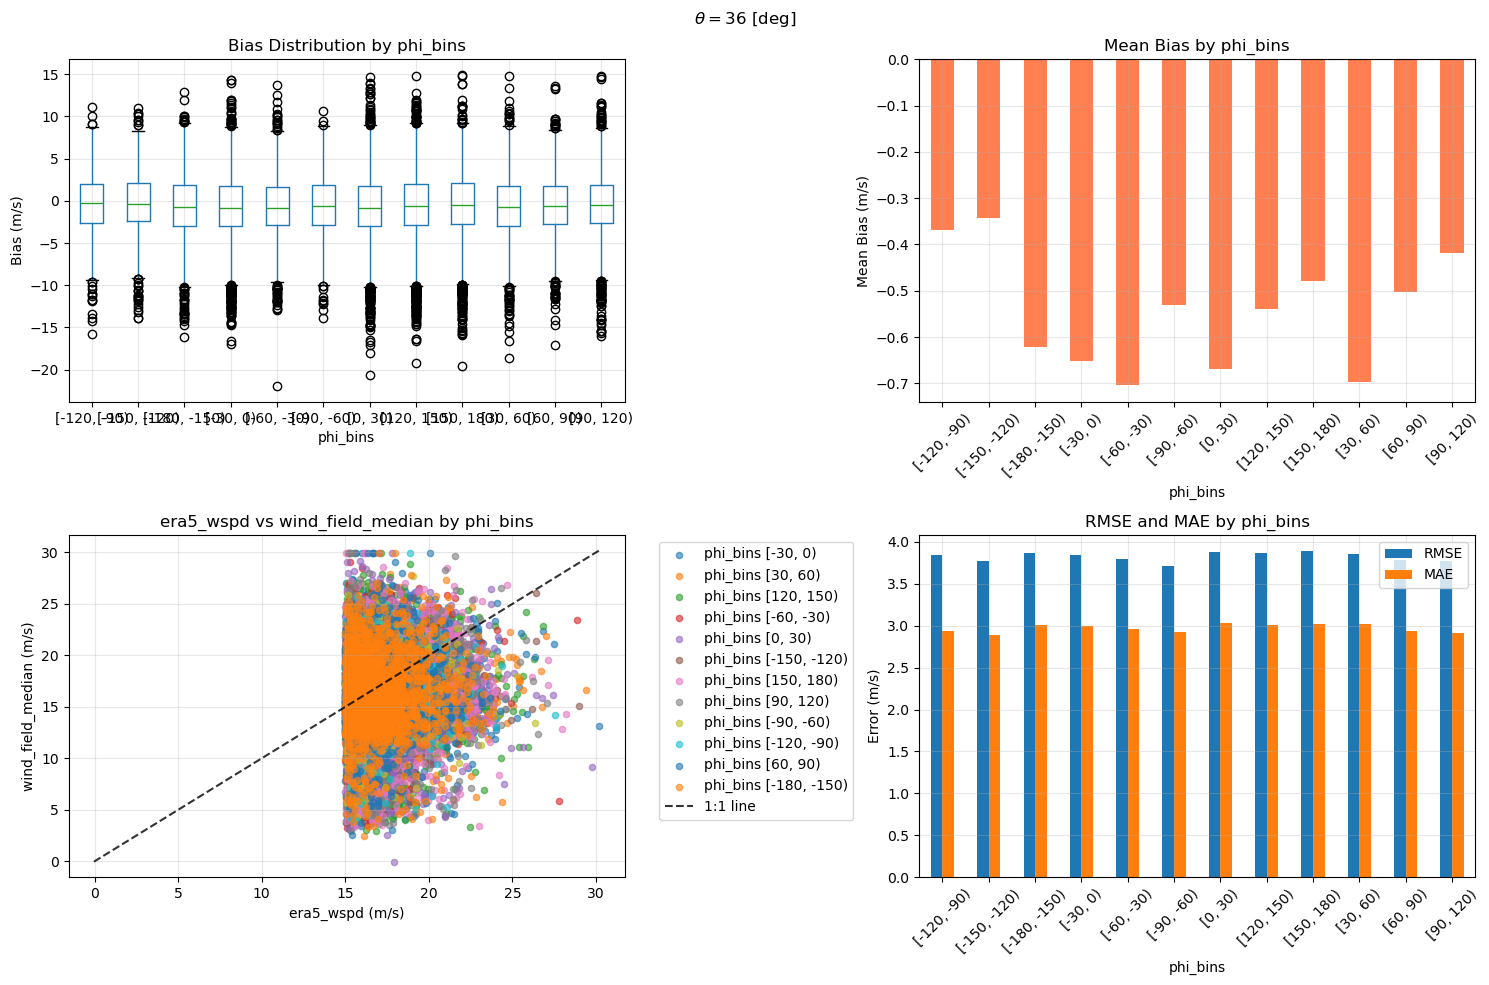


=== INTERPRETATION GUIDE ===
• Mean Bias: Average difference (retrieved - true)
  - Positive = systematic overestimation
  - Negative = systematic underestimation
• MAE: Mean Absolute Error (average magnitude of errors)
• RMSE: Root Mean Square Error (penalizes larger errors more)
• Correlation: Linear relationship strength (-1 to 1)
• Relative Bias %: Bias as percentage of true mean value


In [ ]:
bias_results = analyze_wind_bias(df1w, "$\\theta = 23$ [deg]")
bias_results = analyze_wind_bias(df2w, "$\\theta = 36$ [deg]")

In [4]:
from ndbc_api import NdbcApi

api = NdbcApi()


In [6]:
stations_df = api.stations()

In [8]:
stations_df[stations_df['Station'] == "32ST0"]

,Station,Lat,Lon,Elevation,Name,Owner,Program,Type,Includes Meteorology,Includes Currents,Includes Water Quality,DART Program


In [11]:
met_stations = stations_df[stations_df["Program"] == "NDBC Meteorological/Ocean"]

In [14]:
met_stations

,Station,Lat,Lon,Elevation,Name,Owner,Program,Type,Includes Meteorology,Includes Currents,Includes Water Quality,DART Program
14,1801589,37.450,-122.930,0.0,"SD 1073 - 24 NM SSW of San Francisco, CA (Site...",NDBC,NDBC Meteorological/Ocean,usv,True,False,False,False
87,41001,34.746,-72.415,0.0,EAST HATTERAS - 150 NM East of Cape Hatteras,NDBC,NDBC Meteorological/Ocean,other,True,False,False,False
88,41002,31.743,-74.955,0.0,SOUTH HATTERAS - 225 NM South of Cape Hatteras,NDBC,NDBC Meteorological/Ocean,other,True,False,False,False
89,41004,32.502,-79.099,0.0,"EDISTO - 41 NM Southeast of Charleston, SC",NDBC,NDBC Meteorological/Ocean,other,True,False,False,False
90,41008,31.400,-80.866,0.0,"GRAYS REEF - 40 NM Southeast of Savannah, GA",NDBC,NDBC Meteorological/Ocean,buoy,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1244,srst2,29.683,-94.033,0.7,"Sabine Pass, TX",NDBC,NDBC Meteorological/Ocean,fixed,False,False,False,False
1247,stdm4,47.184,-87.225,182.9,"Stannard Rock, MI",NDBC,NDBC Meteorological/Ocean,fixed,False,False,False,False
1284,tplm2,38.899,-76.436,0.0,"Thomas Point, MD",NDBC,NDBC Meteorological/Ocean,fixed,True,False,False,False
1305,venf1,27.072,-82.453,0.0,"Venice, FL",NDBC,NDBC Meteorological/Ocean,fixed,False,False,False,False


In [15]:
api.station(station_id="srst2")

{'Barometer elevation': '2.4 m above mean sea level',
 'Anemometer height': '9.1 m above site elevation',
 'Air temp height': '9.1 m above site elevation',
 'Site elevation': '0.7 m above mean sea level',
 'Location': '29.683 N 94.033 W (29°41\'0" N 94°2\'0" W)',
 'Statation Type': 'Owned and maintained by National Data Buoy Center, C-MAN Station, MARS payload',
 'Name': 'Station SRST2  - Sabine Pass, TX'}

In [20]:
cwind_df = api.get_data(
    station_id="srst2",
    start_time="2023-01-01",
    end_time="2023-12-31",
    mode="cwind"
)

In [21]:
cwind_df

,,WDIR,WSPD,GDR,GST,GTIME
timestamp,station_id,,,,,
2023-01-01 00:00:00,srst2,157.0,3.7,NaN,NaN,NaN
2023-01-01 00:10:00,srst2,157.0,3.8,NaN,NaN,NaN
2023-01-01 00:20:00,srst2,156.0,3.8,NaN,NaN,NaN
2023-01-01 00:30:00,srst2,156.0,3.7,NaN,NaN,NaN
2023-01-01 00:40:00,srst2,156.0,3.3,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-30 23:20:00,srst2,215.0,3.6,NaN,NaN,NaN
2023-12-30 23:30:00,srst2,213.0,3.6,NaN,NaN,NaN
2023-12-30 23:40:00,srst2,206.0,3.2,NaN,NaN,NaN


In [ ]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=1)
# plot_directional_differences(d, k_valuesa, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)

Performing block bootstrap with 1040 samples, block size 32, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 885.77it/s]


Performing block bootstrap with 1132 samples, block size 33, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 852.04it/s]


Performing block bootstrap with 418 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5436.28it/s]


Performing block bootstrap with 405 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5451.20it/s]


Performing block bootstrap with 254 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 8631.91it/s]


Performing block bootstrap with 255 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 7591.72it/s]


Performing block bootstrap with 237 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 8405.52it/s]


Performing block bootstrap with 259 samples, block size 16, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6118.76it/s]


Performing block bootstrap with 407 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5312.40it/s]


Performing block bootstrap with 446 samples, block size 21, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4467.14it/s]


Performing block bootstrap with 1369 samples, block size 37, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 745.80it/s]


Performing block bootstrap with 1448 samples, block size 38, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 686.71it/s]


Performing block bootstrap with 2278 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 455.67it/s]


Performing block bootstrap with 2381 samples, block size 48, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 399.39it/s]


Performing block bootstrap with 1338 samples, block size 36, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 661.04it/s]


Performing block bootstrap with 1262 samples, block size 35, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 739.06it/s]


Performing block bootstrap with 541 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1389.95it/s]


Performing block bootstrap with 518 samples, block size 22, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1452.81it/s]


Performing block bootstrap with 641 samples, block size 25, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1183.99it/s]


Performing block bootstrap with 542 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 2056.95it/s]


Performing block bootstrap with 1848 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 491.55it/s]


Performing block bootstrap with 1781 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 518.46it/s]


Performing block bootstrap with 2218 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:05<00:00, 173.88it/s]


Performing block bootstrap with 2171 samples, block size 46, and 1000 replicates


100%|██████████| 1000/1000 [00:05<00:00, 169.19it/s]


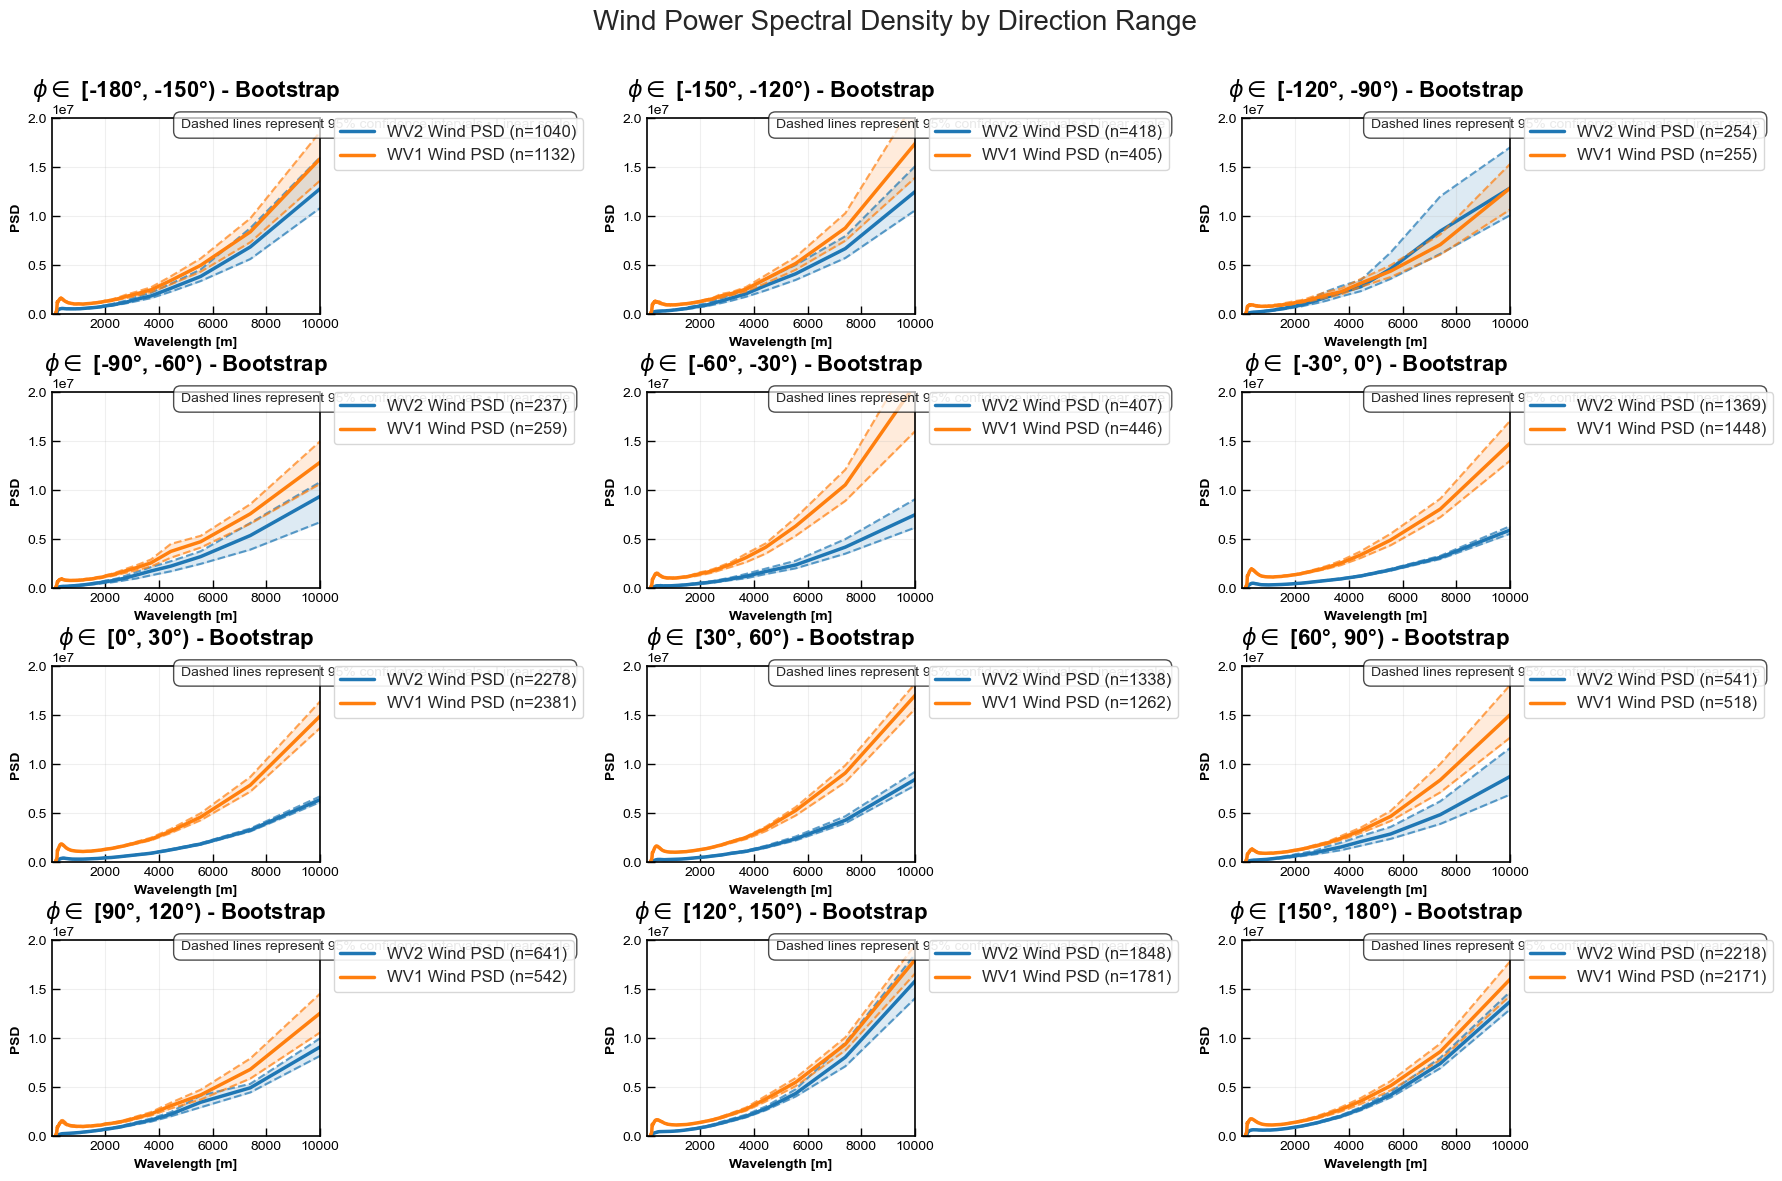

In [57]:
intervals = np.arange(-180, 181, 30)

# Create the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Flatten the 2D array of axes
flat_axes = axes.flatten()

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    # Skip if we've run out of axes
    if i >= len(flat_axes):
        print(f"Warning: Not enough axes for interval {a} to {b}")
        continue
        
    # Get the current axis
    current_ax = flat_axes[i]
    
    # Construct filtered DataFrames for the current interval
    df1_filtered, df1r_filtered, df1w_filtered, df2_filtered, df2r_filtered, df2w_filtered = construct_df(a, b, df1, df1r, df1w, df2, df2r, df2w)
    df1_filtered = filter_similar_atmospheric_conditions(df1_filtered, L_range=(-1e6, -1000))
    df2_filtered = filter_similar_atmospheric_conditions(df2_filtered, L_range=(-1e6, -1000))

    df1r_filtered = df1r_filtered[df1r_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2r_filtered = df2r_filtered[df2r_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    df1w_filtered = df1w_filtered[df1w_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2w_filtered = df2w_filtered[df2w_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # Plot on the current axis
    _, _ = plot_avg_spectral_density(k_values, [df2w_filtered, df1w_filtered],
                              ["WV2 Wind PSD", "WV1 Wind PSD"],
                              f"$\\phi \\in$ [{a}°, {b}°)", 
                              x_range=(0.0001, 0.15), y_range=(0, 0.2e8), 
                              use_log_scale=False, wavelength=True, bootstrap=True,
                              ax=current_ax)  

# Hide any unused axes
for j in range(i+1, len(flat_axes)):
    flat_axes[j].set_visible(False)

# Add a common title for the entire figure
fig.suptitle('Wind Power Spectral Density by Direction Range', fontsize=20, y=0.98)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The rect parameter reserves space for the suptitle

# Show the figure
plt.show()

In [9]:
# df1_m180_m150, df1r_m180_m150, df1w_m180_m150, df2_m180_m150, df2r_m180_m150, df2w_m180_m150 = construct_df(-180, -150, df1, df1r, df1w, df2, df2r, df2w)
# df1_m150_m120, df1r_m150_m120, df1w_m150_m120, df2_m150_m120, df2r_m150_m120, df2w_m150_m120 = construct_df(-150, -120, df1, df1r, df1w, df2, df2r, df2w)
# df1_m120_m90, df1r_m120_m90, df1w_m120_m90, df2_m120_m90, df2r_m120_m90, df2w_m120_m90 = construct_df(-120, -90, df1, df1r, df1w, df2, df2r, df2w)
# df1_m90_m60, df1r_m90_m60, df1w_m90_m60, df2_m90_m60, df2r_m90_m60, df2w_m90_m60 = construct_df(-90, -60, df1, df1r, df1w, df2, df2r, df2w)
# df1_m60_m30, df1r_m60_m30, df1w_m60_m30, df2_m60_m30, df2r_m60_m30, df2w_m60_m30 = construct_df(-60, -30, df1, df1r, df1w, df2, df2r, df2w)
# df1_m30_0, df1r_m30_0, df1w_m30_0, df2_m30_0, df2r_m30_0, df2w_m30_0 = construct_df(-30, 0, df1, df1r, df1w, df2, df2r, df2w)
# df1_0_30, df1r_0_30, df1w_0_30, df2_0_30, df2r_0_30, df2w_0_30 = construct_df(0, 30, df1, df1r, df1w, df2, df2r, df2w)
# df1_30_60, df1r_30_60, df1w_30_60, df2_30_60, df2r_30_60, df2w_30_60 = construct_df(30, 60, df1, df1r, df1w, df2, df2r, df2w)
# df1_60_90, df1r_60_90, df1w_60_90, df2_60_90, df2r_60_90, df2w_60_90 = construct_df(60, 90, df1, df1r, df1w, df2, df2r, df2w)
# df1_90_120, df1r_90_120, df1w_90_120, df2_90_120, df2r_90_120, df2w_90_120 = construct_df(90, 120, df1, df1r, df1w, df2, df2r, df2w)
# df1_120_150, df1r_120_150, df1w_120_150, df2_120_150, df2r_120_150, df2w_120_150 = construct_df(120, 150, df1, df1r, df1w, df2, df2r, df2w)
# df1_150_180, df1r_150_180, df1w_150_180, df2_150_180, df2r_150_180, df2w_150_180 = construct_df(150, 180, df1, df1r, df1w, df2, df2r, df2w)

In [10]:
# df1_reconstructed = pd.concat([df1_m180_m150, df1_m150_m120, df1_m120_m90, df1_m90_m60, df1_m60_m30, df1_m30_0,
#                                df1_0_30, df1_30_60, df1_60_90, df1_90_120, df1_120_150, df1_150_180], ignore_index=True)

# df2_reconstructed = pd.concat([df2_m180_m150, df2_m150_m120, df2_m120_m90, df2_m90_m60, df2_m60_m30, df2_m30_0,
#                                  df2_0_30, df2_30_60, df2_60_90, df2_90_120, df2_120_150, df2_150_180], ignore_index=True)

In [11]:
# filtered_df1 = filter_similar_atmospheric_conditions(df1_reconstructed, L_range=(-1e6, -1000))
# filtered_df2 = filter_similar_atmospheric_conditions(df2_reconstructed, L_range=(-1e6, -1000))
# filtered_df1r = df1r[df1r["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2r = df2r[df2r["renamed_filename"].isin(filtered_df2["renamed_filename"])]
# filtered_df1w = df1w[df1w["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2w = df2w[df2w["renamed_filename"].isin(filtered_df2["renamed_filename"])]

# d = compute_directional_differences(filtered_df1, filtered_df2,
#                                     filtered_df1r, filtered_df2r, 
#                                     filtered_df1w, filtered_df2w, 
#                                     k_values=k_values, phi_res=30)

# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                 max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                 title=f"Directional Differences - Filtered - L_range {(-1e6, -1000)}")

In [12]:
# # wspd_range = (18, 19)
# L_ranges = [(-1e6, -1000), (-1000, -500), (-500, 0)]
# ds = []
# for L_range in L_ranges:
#     filtered_df1 = filter_similar_atmospheric_conditions(df1, L_range=L_range)
#     filtered_df2 = filter_similar_atmospheric_conditions(df2, L_range=L_range)

#     filtered_df1r = df1r[df1r['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2r = df2r[df2r['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1w = df1w[df1w['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2w = df2w[df2w['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1_rg_uw = filter_similar_atmospheric_conditions(df1_rg_uw, L_range=L_range)
#     filtered_df2_rg_uw = filter_similar_atmospheric_conditions(df2_rg_uw, L_range=L_range)
#     filtered_df1r_rg_uw = df1r_rg_uw[df1r_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2r_rg_uw = df2r_rg_uw[df2r_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]
#     filtered_df1w_rg_uw = df1w_rg_uw[df1w_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2w_rg_uw = df2w_rg_uw[df2w_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]

#     filtered_df1_rg_dw = filter_similar_atmospheric_conditions(df1_rg_dw, L_range=L_range)
#     filtered_df2_rg_dw = filter_similar_atmospheric_conditions(df2_rg_dw, L_range=L_range)
#     filtered_df1r_rg_dw = df1r_rg_dw[df1r_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2r_rg_dw = df2r_rg_dw[df2r_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]
#     filtered_df1w_rg_dw = df1w_rg_dw[df1w_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2w_rg_dw = df2w_rg_dw[df2w_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]

#     filtered_df1_az_lr = filter_similar_atmospheric_conditions(df1_az_lr, L_range=L_range)
#     filtered_df2_az_lr = filter_similar_atmospheric_conditions(df2_az_lr, L_range=L_range)
#     filtered_df1r_az_lr = df1r_az_lr[df1r_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2r_az_lr = df2r_az_lr[df2r_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]
#     filtered_df1w_az_lr = df1w_az_lr[df1w_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2w_az_lr = df2w_az_lr[df2w_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]

#     filtered_df1_az_rl = filter_similar_atmospheric_conditions(df1_az_rl, L_range=L_range)
#     filtered_df2_az_rl = filter_similar_atmospheric_conditions(df2_az_rl, L_range=L_range)
#     filtered_df1r_az_rl = df1r_az_rl[df1r_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2r_az_rl = df2r_az_rl[df2r_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]
#     filtered_df1w_az_rl = df1w_az_rl[df1w_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2w_az_rl = df2w_az_rl[df2w_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]

#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_uw, filtered_df1w_rg_uw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg uw", 
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7), 
#                             use_log_scale=False, wavelength=True);

    
#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_dw, filtered_df1w_rg_dw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg dw",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_lr, filtered_df1w_az_lr], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az lr",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_rl, filtered_df1w_az_rl], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az rl",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);

#     d = compute_directional_differences(filtered_df1, filtered_df2,
#                                         filtered_df1r, filtered_df2r, 
#                                         filtered_df1w, filtered_df2w, 
#                                         k_values=k_values, phi_res=5)
    
#     plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                  max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                  title=f"Directional Differences - Filtered - L_range {L_range}")

In [13]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=5)

In [14]:
# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)